## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# read data sets 
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# print shape of data
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [65]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
(df['converted']).mean()*100

11.965919355605511

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
len(df.query('group == "treatment" and landing_page != "new_page"'))

1965

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
treat_not = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]
control_not = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]
# concat the treatment and control attributes the not matching
not_match = pd.concat([treat_not,control_not])
df2 = df 
not_matches=not_match.index
# drop them
df2 = df2.drop(not_matches)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2.user_id.duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.user_id.drop_duplicates(inplace=True)


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()*100

11.959667567149026

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
# p(c|control)
(df.query('group =="control"')['converted']).mean()*100

12.039917935897611

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
#p(c|treatment)
(df.query('group =="treatment"')['converted']).mean()*100

11.891957956489856

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"').count()[0] / df2.shape[0]

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The answer:**
- The population of converted is 11.96 ~ 12%
- Given that an individual was in the control group, the probability of converting are pretty similar to the probability of converting given that an individual was in the treatment group. 
- There is no evidence that ne page leads to more conversions

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The answer is:**
-                         H0:pnew−pold<=0

-                         H1:pnew−pold>0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
P_new = df2['converted'].mean()
P_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
P_old = df2['converted'].mean()
P_old

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# make binomial distribution
new_page_converted = np.random.binomial(1,P_new,n_new).mean()
new_page_converted

0.12018360619636503

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
# make binomial distribution
old_page_converted = np.random.binomial(1,P_old,n_old).mean()

old_page_converted

0.12020044880708179

In [25]:
#p_new - p_old under the null.
P_new - P_old

0.0

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted - old_page_converted

-1.6842610716757966e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
# get the difference 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1,P_new,n_new).mean()
    old_page_converted = np.random.binomial(1,P_old,n_old).mean()
    p_diffs.append(new_page_converted - old_page_converted)
p_diffs = np.array(p_diffs)    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

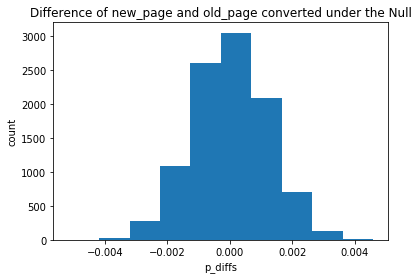

In [28]:
# plot sampling distribution
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('count')
plt.title('Difference of new_page and old_page converted under the Null');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
#the actual probability of converted in treatment group
p_new = df2.query('group == "treatment" ')['converted'].mean()
print(p_new)
p_old = df2.query('group == "control" ')['converted'].mean()
print(p_old)
diff = p_new - p_old
diff

0.118807247903
0.1203863045


-0.0015790565976871451

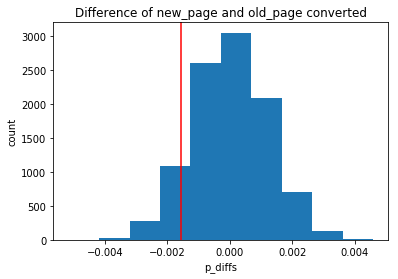

In [30]:
plt.hist(p_diffs)
plt.axvline(x=diff, color='r')
plt.xlabel('p_diffs')
plt.ylabel('count')
plt.title('Difference of new_page and old_page converted');

In [31]:
#P-value
(p_diffs > diff).mean()*100

90.859999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The explain:**
- I was computed the actual difference observed, It is(90.29)
- This value called in scientific studies(P-Value)
- This value mean that we can't reject H0 or the null hypothesis
- Then the old_page is better 


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
n_old = len(df2.query('landing_page != "new_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [33]:
print(convert_new,convert_old)
print(n_new,n_old)

17264 17489
145311 145274


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller')
z_score, p_value

(1.3116075339133115, 0.90517370514059103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- Mean that can't reject H0.
- The p_value is 0.91 and is higher than 0.05 significance level.
- With 95% confidence interval the converted rate of the new_page is larger than the old_page.
- Then the old page is better than the new page
- Finally: yes, I agree

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**The type of regression that I will performing is logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
#creat dummy variable and intercept
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [36]:
# logistic model
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
# print the summary of model
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-30 15:14 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The answer:**
- The p-value associated with ab_page is (0.1897)
- The H0 can't be rejected because 0.19 is above our Type I error threshold of 0.05
- In this case, we are doing a two-tailed test, but in part II the test was one-tailed test

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- Many other factors probably also have influence on whether or not the user converts
- The disadvantage to adding more terms to the regression is complexity that may be difficult to explain

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
#read country data set
dfc = pd.read_csv('countries.csv')
dfc.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
# find the unique in column country 
dfc['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [40]:
# merge the country dataset with ab_data 
df2 = dfc.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df2.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [42]:
# get the dummy variables in country attribute 
df2[['US','UK', 'CA']]= pd.get_dummies(df2['country'])[['US', "UK",'CA']]


In [48]:
# make a logistic model 
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page','CA','US']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-30 15:38 AIC:              212781.3782
No. Observations:   290585           BIC:              212823.6968
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4143  0.0000  -2.0043  -1.9544
ab_page      -0.0150    0.0114    -1.3076  0.1910  -0.0374   0.0075
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
US           -0.0099    0.0133    -0.7437  0.4570  -0.0359   0.0162
==================================================================

"""

- Given that the country(CA,US) were p-values (0.07,0.5) are higher than 0.05, the country (don't influence) or does not appear to have an impact of conversion.
##### conclusions
- reject H1 and don't reject the Null
- The old page is better than new page

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [52]:
# make new variables 
df2['US_ab_page'] = df2.US * df2.ab_page
df2['CA_ab_page'] = df2.CA * df2.ab_page

In [53]:
# test the new variables
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page','CA','US','US_ab_page','CA_ab_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-30 15:57 AIC:              212782.9124
No. Observations:   290585           BIC:              212846.3903
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
US_ab_page   -0.0314    0.0266    -1.1811  0.2375  -0.0835   0.0207
CA_ab_page   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
==================================================================

"""

 ###### Explain
- all variables are still insignificant because p-value is higher than 0.05
 ###### conclusions
- reject H1 and don't reject the Null
- The old page is better than new page

### test the accuracy 

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [59]:
X = df2[['ab_page', 'US', 'CA', 'US_ab_page', 'CA_ab_page']]
y = df2['converted']
# split the data to fit the model and check the accuracy 
X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.20, random_state=0)

In [60]:
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train)
preds = log_mod.predict(X_test)
#print confusion matrix
confusion_matrix(y_test, preds) 

array([[51209,     0],
       [ 6908,     0]])

In [63]:
#print the acc
accuracy_score(y_test, preds)

0.88113632844090373

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0